# Kepler-1544 b

In [3]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

planets = Table.read('../../planets2.txt', format='csv', comment='#')
K1544b = planets[planets['pl_name'] == 'Kepler-1544 b'][0]
print(K1544b['pl_name', 'sy_jmag', 'st_teff', 'pl_rade'])

   pl_name    sy_jmag st_teff pl_rade
------------- ------- ------- -------
Kepler-1544 b   12.48  4820.0    1.79


### Compute the probabilistic mass using Kipping & Chen: https://iopscience.iop.org/article/10.3847/1538-4357/834/1/17

In [4]:
import sys
sys.path.append('/Users/tgordon/research/exomoons/forecaster')
import mr_forecast as mr

res = mr.Rstat2M(mean=K1544b['pl_radj'], std=K1544b['pl_radjerr1'], unit='Jupiter', sample_size=1000, grid_size=200)
print(res)

(0.013681998974147328, 0.009345940598853108, 0.005552869777193421)


### Compute the hill sphere

In [18]:
mj_ms = 0.0009543
hill = lambda mp, ms, a, e: a * (1 - e) * (mp * mj_ms/(3*ms)) ** (1./3.)

a = 0.5421, 0.5421+0.0069, 0.5421-0.0088
e = 0, 0, 0
likely_hill = hill(res[0], K1544b['st_mass'], a[0], e[0])
pessimistic_hill = hill(res[0]-res[1], K1544b['st_mass']-0.03, a[1], e[2])
optimistic_hill = hill(res[0]+res[1], K1544b['st_mass']+0.03, a[2], e[1])
print(likely_hill, " ", pessimistic_hill, " ", optimistic_hill)

0.009785279646927403   0.006850240588658215   0.011300064577242462


### Look at the light curve to assess variability and rotation:

In [31]:
import lightkurve as lk
lcfs = lk.search_lightcurvefile('Kepler-1544', mission='Kepler').download_all()
lc = lcfs.PDCSAP_FLUX.stitch()

/usr/local/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


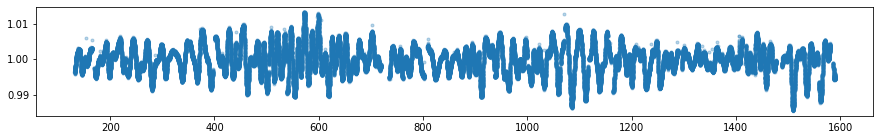

In [32]:
clipped_lc = lc.remove_outliers(sigma=10)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_lc.flux, '.', alpha=0.3)

### Compute the power spectrum of the combined Kepler light curve

(1, 1000000.0)

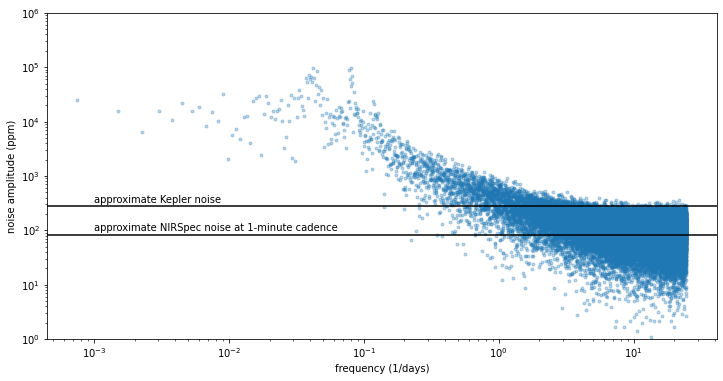

In [29]:
f = np.fft.rfftfreq(len(clipped_lc.flux), clipped_lc.time[1] - clipped_lc.time[0])
fft = np.fft.rfft(clipped_lc.flux)
fft = fft*np.conj(fft)
powerfft = fft.real / len(clipped_lc.time)**2
ampfft = np.sqrt(powerfft * (60 * 60 * 24) / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, ampfft, '.', alpha=0.3)

pl.axhline(280, color='k')
pl.axhline(82, color='k')
pl.annotate(s='approximate Kepler noise', xy=(1e-3, 320))
pl.annotate(s='approximate NIRSpec noise at 1-minute cadence', xy=(1e-3, 100))

pl.ylabel("noise amplitude (ppm)")
pl.xlabel("frequency (1/days)")

pl.ylim(1, 1e6)

In [34]:
# approximate white noise of 200 ppm converted to S0 hyperparam
ppm = 280
S0 = (((ppm * 1e-6 ) ** 2) / 50) / 10
print('Maximum S0 value for {0} ppm white noise is {1}'.format(ppm, S0))

Maximum S0 value for 280 ppm white noise is 1.5679999999999997e-10


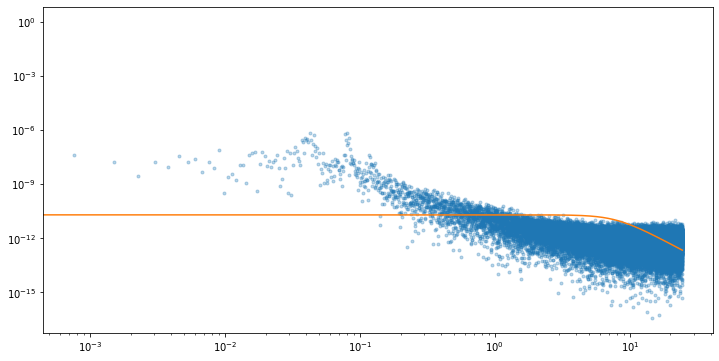

In [35]:
from scipy.optimize import minimize
import celerite2
from celerite2 import terms

pl.figure(figsize=(12, 6))
pl.loglog(f, powerfft, '.', alpha=0.3)

# just making this up but it looks good 
term = terms.SHOTerm(S0=S0, w0=50, Q=1/np.sqrt(2))

psd = term.get_psd(2*np.pi*f)
psd /= (2*np.pi)

pl.loglog(f, psd)

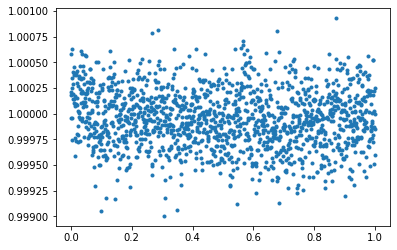

In [36]:
wn = lambda ppm: np.random.randn(len(t)) * ppm * 1e-6

gp = celerite2.GaussianProcess(term, mean=0.0)

# one day
t = np.linspace(0, 1, 1*60*24)
gp.compute(t, yerr = 0)

# A realization of the Kepler granulation component with no white noise 
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)
pl.plot(t, fk + wn(ppm), '.')

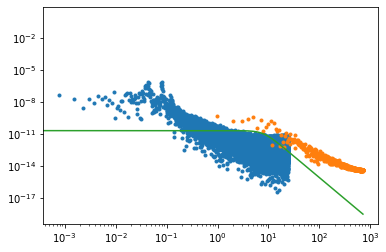

In [37]:
#fk += np.random.randn(len(fk)) * 65 * 1e-6
f_sim = np.fft.rfftfreq(len(fk), t[1]-t[0])
fft_sim = np.fft.rfft(fk)
fft_sim = fft_sim*np.conj(fft_sim)
powerfft_sim = fft_sim.real / len(fk)**2

psd = term.get_psd(2*np.pi*f_sim)
psd /= (2*np.pi)

pl.loglog(f, powerfft, '.')
pl.loglog(f_sim, powerfft_sim, '.')
pl.loglog(f_sim, psd)

In [43]:
import sys
sys.path.append('../')
import generate_noise
import imp
imp.reload(generate_noise)

factors, data = generate_noise.variability_factors(fk, cold_temp=4700, hot_temp=4800, effective_temp=4700, spec_path='../../JexoSim/archive')

../generate_noise.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  flux_hot_kep = quad(int_hot_kep, np.min(kep_band[0])/1e3, np.max(kep_band[0])/1e3)
../generate_noise.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perh

In [44]:
82 * np.sqrt(3)

142.02816622064793

(0.9985, 1.0015)

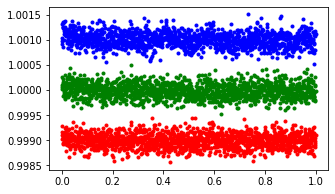

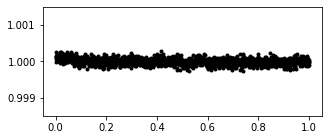

In [45]:
wn = lambda ppm: np.random.randn(len(t)) * ppm * 1e-6

b1 = np.sum(data[:100], axis=0)/np.mean(np.sum(data[:100], axis=0)) + wn(142)
b2 = np.sum(data[100:200], axis=0)/np.mean(np.sum(data[100:200], axis=0)) + wn(142)
b3 = np.sum(data[200:], axis=0)/np.mean(np.sum(data[200:], axis=0)) + wn(142)
ball = np.sum(data, axis=0)/np.mean(np.sum(data, axis=0))

pl.figure(figsize=(5, 3))
pl.plot(t, b1+0.001, 'b.', alpha=1)
pl.plot(t, b2, 'g.', alpha=1)
pl.plot(t, b3-0.001, 'r.', alpha=1)
#pl.plot(t, ball, 'k')
#pl.xlim(0, 1)
pl.figure(figsize=(5, 2))
pl.plot(t, ball + wn(82), 'k.')
pl.ylim(0.9985, 1.0015)

Additional references: 

